<a href="https://colab.research.google.com/github/SamusRam/colab_notebooks/blob/main/TerpeneMiner_(upload_your_structure).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##TerpeneMiner


<img src="https://raw.githubusercontent.com/pluskal-lab/TerpeneMiner/refs/heads/main/data/readme_figures/fig_overview.png" height="300" align="center" style="height:240px">


[TerpeneMiner](https://github.com/pluskal-lab/TerpeneMiner/tree/main) is a state-of-the-art predictor of terpene synthase activity.

[Samusevich, R., Hebra, T. et al. Highly accurate discovery of terpene synthases powered by machine learning reveals functional terpene cyclization in Archaea. bioRxiv, 2024](https://doi.org/10.1101/2024.01.29.577750)

In [1]:
#@title Hit `Runtime` -> `Run all`, then upload a PDB file with the protein structure

# Install and load dependencies
import os
os.system('pip install py3Dmol')
os.system('pip install rdkit')
import requests
from requests.exceptions import JSONDecodeError
from pathlib import Path
import py3Dmol
import matplotlib.pyplot as plt
from dataclasses import dataclass
import re
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from rdkit import Chem
from IPython.display import display, HTML
import sys
from google.colab import output
import time
from google.colab import files
uploaded = files.upload()
is_structure_predicted = True #@param {type:"boolean"}
is_bfactor_prediction_confidence = is_structure_predicted

Saving A0A5E4I9B1.pdb to A0A5E4I9B1.pdb


In [2]:
#@title Detect and analyze structural domains
import requests
import json
# The URL of the FastAPI endpoint
url = "http://147.231.128.68:9994/detect_domains/"

pdb_file = Path(list(uploaded.keys())[0])
is_bfactor_confidence_data = {'is_bfactor_confidence': str(is_bfactor_prediction_confidence).lower()}
if pdb_file.exists():
  with open(pdb_file, 'rb') as file_to_send:
      files = {'file': file_to_send}
      try:
        structural_predictions = requests.post(url, files=files, data=is_bfactor_confidence_data).json()
      except JSONDecodeError:
        structural_predictions = None

In [3]:
#@title Getting comparisons to the known domains
url = "http://147.231.128.68:9994/download_pdb/"

if structural_predictions['aligned_pdb_filepaths'] is not None:
  for module_id, alignment_details in structural_predictions['aligned_pdb_filepaths'].items():
    aligned_pdb_filename = alignment_details['aligned_pdb_name']
    response = requests.get(f"{url}{aligned_pdb_filename}")

    with open(f"{aligned_pdb_filename}.pdb", "wb") as f:
        f.write(response.content)
else:
  print("No TPS domains were detected!")

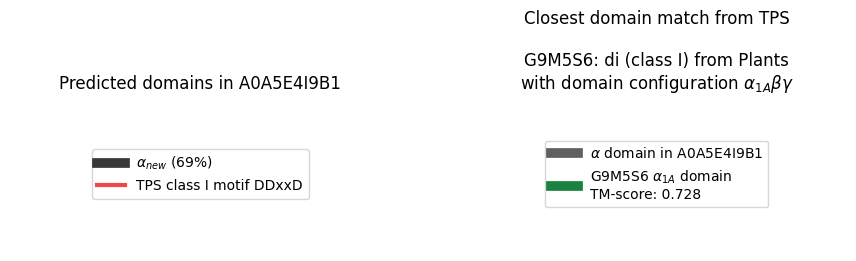

3Dmol.js failed to load for some reason. Please check your browser console for error messages.

In [4]:
#@title Display predicted domains with comparisons to the closest known domains


def compress_selection_list(selected_residues: list[int]) -> str:
    """
    Compresses a list of selected residues into a concise string representation.

    :param selected_residues: A list of residue numbers to be compressed

    :return: A string representing the compressed form of the residue list, with consecutive residues represented
             as ranges (e.g., "1-3+5+7-10")
    """
    sorted_residues = sorted(map(int, selected_residues))
    start_res = None
    intervals = []
    for res in sorted_residues:
        if start_res is None:
            start_res = res
        else:
            if prev_res + 1 != res:
                if start_res == prev_res:
                    intervals.append(f"{start_res}")
                else:
                    intervals.append(f"{start_res}-{prev_res}")
                start_res = res
        prev_res = res

    if start_res is not None:
        if start_res == prev_res:
            intervals.append(f"{start_res}")
        else:
            intervals.append(f"{start_res}-{prev_res}")
    return intervals

def show_domains(structural_predictions, pdb_file):
    protein_id = ''.join(re.sub(r'\(.*?\)', '', pdb_file.stem).split())
    regions = structural_predictions['domains'][protein_id]
    colors_map = {}
    domain_names_with_colors = []
    type_2_display_name = {
        'alpha1A': '$\\alpha_{1A}$',
        'alpha1B': '$\\alpha_{1B}$',
        'alpha2A': '$\\alpha_{2A}$',
        'alpha2B': '$\\alpha_{2B}$',
        'alpha2C': '$\\alpha_{2C}$',
        'alpha2D': '$\\alpha_{2D}$',
        'alpha2E': '$\\alpha_{2E}$',
        'alpha2F': '$\\alpha_{2F}$',
        'alpha3A': '$\\alpha_{3A}$',
        'alpha3B': '$\\alpha_{3B}$',
        'alpha4A': '$\\alpha_{4A}$',
        'alpha4B': '$\\alpha_{4B}$',
        'alpha4C': '$\\alpha_{4C}$',
        'beta': '$\\beta$',
        'delta1': '$\\delta_1$',
        'delta2': '$\\delta_2$',
        'epsilon': '$\\epsilon$',
        'gamma': '$\\gamma$'
    }

    colors = {
        "$\\alpha_{1A}$": "#1A8140",
        "$\\alpha_{1B}$": "#1A8140",
        "$\\alpha_{2A}$": "#B11F6F",
        "$\\alpha_{2B}$": "#B11F6F",
        "$\\alpha_{2C}$": "#B11F6F",
        "$\\alpha_{2D}$": "#B11F6F",
        "$\\alpha_{2E}$": "#B11F6F",
        "$\\alpha_{2F}$": "#B11F6F",
        "$\\alpha_{3A}$": "#954921",
        "$\\alpha_{3B}$": "#954921",
        "$\\alpha_{4A}$": "#606161",
        "$\\alpha_{4B}$": "#606161",
        "$\\alpha_{4C}$": "#606161",
        "$\\beta$": "#DCC225",
        "$\\gamma$": "#554C9F",
        "$\\delta_1$": "#4068B1",
        "$\\delta_2$": "#283989",
        "$\\epsilon$": "#FFC0CB",
        "$\\alpha_{new}": "#3A3737",
        "$\\beta_{new}": "#3A3737",
        "$\\gamma_{new}": "#3A3737",
        "$\\delta_{new}": "#3A3737",
        "$\\epsilon_{new}": "#3A3737"
    }
    motif_colors = {"DDxxD": "#F04848", "NSE/DTE": "#E990BD", "DxDD": "#5D9BD3"}

    for region_ in regions:
        mapped_residues = set(region_['residues_mapping'].keys())
        module_id = region_['module_id']
        pred_domain_type, confidence = max(structural_predictions['domain_type_predictions'][module_id].items(), key=lambda x: x[1])
        if region_['domain'] == 'alphaWeird':
            region_['domain'] = 'alpha'
            pred_domain_type, confidence = 'novel', 0.99
        if pred_domain_type in type_2_display_name:
            domain_name_current = type_2_display_name[pred_domain_type]
        else:
            assert pred_domain_type in {'novel', 'missing'}
            pred_domain_type = 'novel'
            domain_name_current = f"$\\{region_['domain']}" + "_{new}$"
        color = colors.get(domain_name_current, "#3A3737")
        domain_names_with_colors.append([f"{domain_name_current} ({100*confidence:.0f}%)", color])
        for res in mapped_residues:
            colors_map[res] = color
    for sequence_motif in structural_predictions['motif_detections']:
       for res in range(sequence_motif['start'], sequence_motif['end']):
          colors_map[res] = motif_colors[sequence_motif['motif']]
    with open(pdb_file, "r") as file:
        af2_struct = file.read()

    max_window_width_retries = 5
    window_width = 0
    width_retrieval_attempt = 0
    while window_width == 0 and width_retrieval_attempt < max_window_width_retries:
      window_width = output.eval_js('window.innerWidth')
      time.sleep(0.1)
      width_retrieval_attempt += 1
    if window_width == 0:
      window_width = 900
    window_width = min(700*(len(regions) + 1), window_width)

    per_region_width = window_width // (len(regions) + 1)
    view = py3Dmol.view(js="https://3dmol.org/build/3Dmol.js", width=per_region_width * (1 + len(regions)), height=per_region_width, viewergrid=(1, 1 + len(regions)), linked=True)
    view.addModel(af2_struct, "pdb",viewer=(0,0))
    view.setStyle({'cartoon': {'thickness': 0.1, 'width': 0.2}}, viewer=(0,0))
    for interval in compress_selection_list(structural_predictions['secondary_structure_residues']):
      view.setStyle({'resi': interval}, {'cartoon': {'thickness': 1.5, 'width': 2.0, "colorscheme": {"prop": "resi", "map": colors_map}}}, viewer=(0,0))
    view.zoomTo(viewer=(0, 0))

    similar_domains = []
    for domain_i, region_ in enumerate(regions):
        module_id = region_['module_id']
        similar_domain = structural_predictions['aligned_pdb_filepaths'][module_id]
        aligned_pdb_name = f"{similar_domain['aligned_pdb_name']}.pdb"
        with open(aligned_pdb_name, "r") as file:
            aligned_struct = file.read()
        view.addModel(aligned_struct, 'pdb', viewer=(0,domain_i + 1))
        domain_name_closest = type_2_display_name.get(similar_domain['closest_domain_type'], similar_domain['closest_domain_type'])
        color = colors.get(domain_name_closest, "#3A3737")
        pred_domain_type, confidence = max(structural_predictions['domain_type_predictions'][module_id].items(), key=lambda x: x[1])

        view.setStyle({'chain': 'A'}, {'cartoon': {'color': color}}, viewer=(0, domain_i + 1))
        detected_domain_color = colors.get(type_2_display_name.get(pred_domain_type, ""), "#3A3737")
        view.setStyle({'chain': 'B'}, {'cartoon': {'color': detected_domain_color, 'opacity': 0.8}}, viewer=(0, domain_i + 1))
        view.zoomTo(viewer=(0, domain_i + 1))
        similar_domains.append((pred_domain_type if pred_domain_type not in {'novel', 'missing'} else region_['domain'], detected_domain_color, color, similar_domain))


    # legend
    px = 1/plt.rcParams['figure.dpi']
    fig, ax = plt.subplots(1, 1 + len(regions), figsize=(1.2*window_width*px, 2))
    for domain, color in domain_names_with_colors:
        ax[0].plot([], [], color=color, label=domain, linewidth=7)
    for sequence_motif in structural_predictions['motif_detections']:
        class_tps = sequence_motif['class_tps']
        ax[0].plot([], [], color=motif_colors[sequence_motif['motif']], label=f"TPS {class_tps} motif {sequence_motif['motif']}", linewidth=3)
    ax[0].legend(loc="center", ncol=1)
    ax[0].set_title(f"Predicted domains in {protein_id}")
    ax[0].axis("off")

    for closest_domain_i, (detected_domain_type, detected_domain_color, similar_domain_color_type, similar_domain_dict) in enumerate(similar_domains):
        ax[closest_domain_i + 1].plot([], [], color=detected_domain_color, label=f"$\\{detected_domain_type}$ domain in {protein_id}", linewidth=7, alpha=0.8)
        domain_name_closest = type_2_display_name.get(similar_domain_dict['closest_domain_type'], similar_domain_dict['closest_domain_type'])
        ax[closest_domain_i + 1].plot([], [], color=similar_domain_color_type, label=f"{similar_domain_dict['closest_known_domain_pdb_id']} {domain_name_closest} domain\nTM-score: {similar_domain_dict['tm_score']:.3f}", linewidth=7)
        ax[closest_domain_i + 1].legend(loc="center", ncol=1)
        whole_domain_config = [type_2_display_name.get(dom_type, dom_type) for dom_type in similar_domain_dict['whole_structure_domain_config']]
        ax[closest_domain_i + 1].set_title(f"Closest domain match from TPS\n\n{similar_domain_dict['closest_known_domain_pdb_id']}: {'|'.join(similar_domain_dict['closest_id_reaction_types'])} from {similar_domain_dict['closest_id_kingdom']}\nwith domain configuration {''.join(whole_domain_config)}")
        ax[closest_domain_i + 1].axis("off")
    plt.show()

    return view

if pdb_file.exists() and structural_predictions['aligned_pdb_filepaths'] is not None and structural_predictions['domain_type_predictions']:
  display(show_domains(structural_predictions, pdb_file))
else:
  print("No TPS domains were detected!")

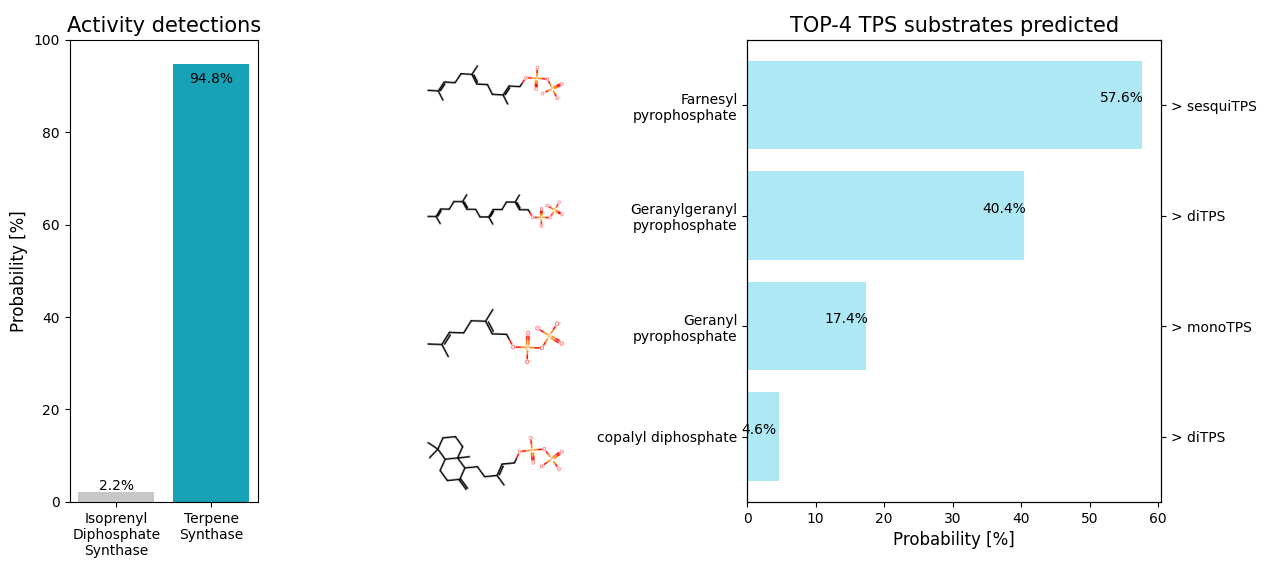

In [5]:
#@title Get TPS activity predictions
url = "http://147.231.128.68:9994/predict_tps/"

is_bfactor_confidence_data = {'is_bfactor_confidence': str(is_bfactor_prediction_confidence).lower()}
if pdb_file.exists():
    with open(pdb_file, 'rb') as file_to_send:
        files = {'file': file_to_send}
        try:
          substr_predictions = requests.post(url, files=files, data=is_bfactor_confidence_data).json()
        except JSONDecodeError:
          print("No predictions")
          substr_predictions = None

    if substr_predictions is not None:
        fig = plt.figure(figsize=(17, 6))
        gs = gridspec.GridSpec(1, 6)  # 2 rows, 3 columns grid

        detection_probs = [substr_predictions['predictions'][0][key]*100 for key in ['precursor substr', 'isTPS']]


        ax1 = fig.add_subplot(gs[0, 0])
        if detection_probs[1] > 30:
            ax2 = fig.add_subplot(gs[0, 3:5])
        ax1.bar(['Isoprenyl\nDiphosphate\nSynthase', 'Terpene\nSynthase'], detection_probs, color=['#c7c7c7', '#17A2B8'])
        ax1.set_ylim((0, 100))
        ax1.set_title('Activity detections', fontsize=15)
        ax1.set_ylabel('Probability [%]', fontsize=12)
        for i, value in enumerate(detection_probs):
            ax1.text(i, max(2, value - max(detection_probs)*0.05), f"{value:.1f}%", ha='center', va='bottom')

        if detection_probs[1] > 30:
            substrate_predictions = [(subst, pred) for subst, pred in substr_predictions['predictions'][0].items() if subst not in {'precursor substr', 'isTPS'}]
            substrate_predictions_top = sorted(substrate_predictions, key=lambda x: x[1])[-4:]

            substr_2_type = {"CC(C)=CCCC(C)=CCCC(C)=CCOP([O-])(=O)OP([O-])([O-])=O": "sesquiTPS",
                            "CC(C)=CCCC(C)=CCOP([O-])(=O)OP([O-])([O-])=O": "monoTPS",
                            "CC(C)=CCCC(C)=CCCC(C)=CCCC(C)=CCOP([O-])(=O)OP([O-])([O-])=O":  "diTPS",
                            "CC(C)=CCCC(C)=CCCC(C)=CCCC=C(C)CCC=C(C)CCC1OC1(C)C": "triTPS (class II)",
                            "CC1(C)CCCC2(C)C1CCC(=C)C2CCC(C)=CCOP([O-])(=O)OP([O-])([O-])=O": "diTPS",
                            "CC(C)=CCCC(C)=CCCC(C)=CCCC(C)=CCCC(C)=CCOP([O-])(=O)OP([O-])([O-])=O": "sesterTPS",
                            "CC(C)=CCCC(C)=CCCC(C)=CCOP([O-])(=O)OP([O-])([O-])=O.CC(C)=CCCC(C)=CCCC(C)=CCOP([O-])(=O)OP([O-])([O-])=O":  "triTPS (squalene synthase)",
                            "CC(C)=CCCC(C)=CCCC(C)=CCCC(C)=CCOP([O-])(=O)OP([O-])([O-])=O.CC(C)=CCCC(C)=CCCC(C)=CCCC(C)=CCOP([O-])(=O)OP([O-])([O-])=O": "tetraTPS"}
            substr_2_name = {"CC(C)=CCCC(C)=CCCC(C)=CCOP([O-])(=O)OP([O-])([O-])=O": "Farnesyl\npyrophosphate",
                            "CC(C)=CCCC(C)=CCOP([O-])(=O)OP([O-])([O-])=O": "Geranyl\npyrophosphate",
                            "CC(C)=CCCC(C)=CCCC(C)=CCCC(C)=CCOP([O-])(=O)OP([O-])([O-])=O":  "Geranylgeranyl\npyrophosphate",
                            "CC(C)=CCCC(C)=CCCC(C)=CCCC=C(C)CCC=C(C)CCC1OC1(C)C": "(S)-2,3-epoxysqualene",
                            "CC1(C)CCCC2(C)C1CCC(=C)C2CCC(C)=CCOP([O-])(=O)OP([O-])([O-])=O": "copalyl diphosphate",
                            "CC(C)=CCCC(C)=CCCC(C)=CCCC(C)=CCCC(C)=CCOP([O-])(=O)OP([O-])([O-])=O": "Geranylfarnesyl\npyrophosphate",
                            "CC(C)=CCCC(C)=CCCC(C)=CCOP([O-])(=O)OP([O-])([O-])=O.CC(C)=CCCC(C)=CCCC(C)=CCOP([O-])(=O)OP([O-])([O-])=O":  "2x Farnesyl\npyrophosphate",
                            "CC(C)=CCCC(C)=CCCC(C)=CCCC(C)=CCOP([O-])(=O)OP([O-])([O-])=O.CC(C)=CCCC(C)=CCCC(C)=CCCC(C)=CCOP([O-])(=O)OP([O-])([O-])=O": "2x Geranylgeranyl\npyrophosphate"}

            for smiles_i, (smiles, _) in enumerate(substrate_predictions_top):
                mol = Chem.MolFromSmiles(smiles)
                im = Chem.Draw.MolToImage(mol, size=(200, 200))
                ax_ = plt.axes([0.25, 0.21*smiles_i + 0.05, 0.25, 0.25], frameon=True)
                ax_.imshow(im)
                ax_.axis('off')

            probabilities = [100*prob for _, prob in substrate_predictions_top]
            max_prob = max(probabilities)
            ax2.barh([substr_2_name[smiles] for smiles, _ in substrate_predictions_top], probabilities, color='#ADE8F4')
            for i, value in enumerate(probabilities):
                ax2.text(max(1, value - max_prob*0.05), i, f"{value:.1f}%", ha='center', va='bottom')
            if max_prob == 0:
                ax2.set_xlim((0, 5))

            ax2_secondary_ylabels = ax2.twinx()
            ax2_secondary_ylabels.set_ylim(ax2.get_ylim())
            ax2_secondary_ylabels.set_yticks(ax2.get_yticks())
            ax2_secondary_ylabels.set_yticklabels([f'> {substr_2_type[smiles]}' for smiles, _ in substrate_predictions_top])

            ax2.set_title('TOP-4 TPS substrates predicted', fontsize=15)
            _ = ax2.set_xlabel('Probability [%]', fontsize=12)